In [ ]:
# ....... look into filtered merged Cui et al data ....... #

In [2]:
library(SingleCellExperiment)
library(Matrix)
library(MetaNeighbor)
library(MetaMarkers)
library(scater)
library(dplyr)

In [3]:
cuimat = read.delim('~/heart/GSE106118_UMI_count_merge.txt', sep = '\t')
cuicls = read.delim('~/heart/cui_cluster_anno.csv', sep = ',')
# cuibarcodes = read.delim('~/heart/GSE106118_barcode_information.txt', sep = '\t')

In [4]:
# scRNA-seq - wow!
mean(colSums(cuimat, na.rm = T))
median(colSums(cuimat, na.rm = T))
dim(cuimat)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'mean': 'x' must be numeric


In [2]:
ginfo = read.delim('/data/CoCoCoNet/geneInfo/human_info.csv', sep = ',')
zinfo = read.delim('/data/CoCoCoNet/geneInfo/zebrafish_info.csv', sep = ',')

In [6]:
om = read.delim('/data/CoCoCoNet/orthologMaps/zebrafish_human_orthoNM.csv', sep = ',')
om[1:3,]

zebrafish          human           zebrafish_OrthoID human_OrthoID
1 ENSDARG00000063922 ENSG00000198695 7955_0:0072ac     9606_0:000000
2 ENSDARG00000063914 ENSG00000198840 7955_0:0072ad     9606_0:000001
3 ENSDARG00000063899 ENSG00000198763 7955_0:0072b0     9606_0:000002

In [7]:
genes = unlist(cuimat[,1])
cuimat <- as.matrix(cuimat[,-1])
rownames(cuimat) = genes

cuimat[1:2,1:3]

HE5W_1_LA.1 HE5W_1_LA.2 HE5W_1_LA.3
A1BG     0           0           0          
A1BG-AS1 0           0           0

In [8]:
# subset to 3842 cells with anno
mat2 = cuimat[,which(!is.na(match(colnames(cuimat), cuicls$Cell.Name)))]

# SCE object
mat2 = SingleCellExperiment(mat2)
colData(mat2)$Cluster = cuicls$Cluster[match(colnames(mat2), cuicls$Cell.Name)]
colData(mat2)$Dataset = 'Cui'
rownames(colData(mat2)) = colnames(mat2)

rownames(mat2) <- ginfo$EnsemblID[match(rownames(mat2), ginfo$GeneSymbol)]
mat2 <- mat2[!is.na(rownames(mat2)),]
rowData(mat2)$Gene = rownames(mat2)
rowData(mat2)$Symbol = ginfo$GeneSymbol[match(rownames(mat2), ginfo$EnsemblID)]

assay(mat2, "cpm") = convert_to_cpm(assay(mat2))
assayNames(mat2) <- c('counts', 'cpm')

In [13]:
# 3842 of 4948 cells have cluster anno
table(cuicls$Cluster)


                  C1 (5W)                   C2 (CM) C3 (Fibroblast-like cell) 
                      257                      1492                       786 
                  C4 (EC)          C5 (Valvar cell)                   C6 (EP) 
                      445                       427                        46 
           C7 (Mast cell)           C8 (Macrophage)            C9 (B/T cells) 
                       27                       304                        58 

In [9]:
mat2

class: SingleCellExperiment 
dim: 20855 3842 
metadata(0):
assays(2): counts cpm
rownames(20855): ENSG00000121410 ENSG00000268895 ... ENSG00000074755
  ENSG00000036549
rowData names(2): Gene Symbol
colnames(3842): HE5W_1_LA.1 HE5W_1_LA.3 ... HE23W_2_RV.22 HE23W_2_RV.24
colData names(2): Cluster Dataset
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [10]:
start.time <- Sys.time()
hvg = variableGenes(mat2, exp_labels = mat2$Cluster)
# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

Time difference of 2.142637 secs

[1] 304

In [1]:
# load zebrafish devp data
aa = read.delim('~/heart/ZCA_GSM4274624_72hpf_2_dge.txt', sep = '\t')

In [12]:
mat3 = as.matrix(aa[,-1])
features = unlist(aa[,1])
mat3 = SingleCellExperiment(mat3)
rownames(mat3) = features

In [13]:
gz1 = zinfo$NetworkIDs[match(toupper(features), toupper(zinfo$GeneSymbol))]
rownames(mat3) = om$human[match(gz1, om$zebrafish)]
mat3 <- mat3[!is.na(rownames(mat3)),]

In [14]:
dim(mat3)

[1] 14486 10000

In [15]:
barcodes = read.delim('~/heart/zca_cell_barcode_anno.csv', sep = ',')

In [41]:
tail(barcodes)

cell.barcode             Cluster       Annotation         
201089 Z72h2.ACGTTGATACAGTAGCAT Z72h_cluster9 Z72h.Muscle cell   
201090 Z72h2.CATCCCCAACAACGTATT Z72h_cluster1 Z72h.Hatching gland
201091 Z72h2.CCAGACCCGACGAGCGAG Z72h_cluster1 Z72h.Hatching gland
201092 Z72h2.CCGCTAACACCCAAAGTT Z72h_cluster1 Z72h.Hatching gland
201093 Z72h2.CGGCAGGGACATCTGTGT Z72h_cluster1 Z72h.Hatching gland
201094 Z72h2.CTCCATATCTCTTGCGGA Z72h_cluster8 Z72h.Pancreas cell

In [16]:
cellid = paste0('Z72h2.', colnames(mat3))
colData(mat3)$Cluster = barcodes$Annotation[match(cellid, barcodes[,1])]
colData(mat3)$Cluster <- sub('.*\\.', '', colData(mat3)$Cluster)
colData(mat3)$Dataset = 'zebrafish'
mat3 <- mat3[,!is.na(colData(mat3)$Cluster)]

In [23]:
assay(mat3, "cpm") = convert_to_cpm(assay(mat3))
assayNames(mat3) <- c('counts', 'cpm')

In [27]:
# subset to common genes
cgenes = intersect(rownames(mat2), rownames(mat3))
mat2 <- mat2[cgenes,]
mat3 <- mat3[cgenes,]
rowData(mat3) <- rowData(mat2)

In [31]:
mat3

class: SingleCellExperiment 
dim: 8948 7689 
metadata(0):
assays(2): counts cpm
rownames(8948): ENSG00000175899 ENSG00000184389 ... ENSG00000074755
  ENSG00000036549
rowData names(2): Gene Symbol
colnames(7689): CTGTGTATACAGTTCATA GGTACAACACCCGAATTA ...
  CGGCAGGGACATCTGTGT CTCCATATCTCTTGCGGA
colData names(2): Cluster Dataset
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [32]:
# scRNA-seq - wow!
mean(colSums(counts(mat3), na.rm = T))
median(colSums(counts(mat3), na.rm = T))
dim(mat3)

[1] 562.8253

[1] 415

[1] 8948 7689

In [33]:
start.time <- Sys.time()
hvg = variableGenes(mat2, exp_labels = mat2$Cluster)
# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

Time difference of 0.7820694 secs

[1] 81

In [34]:
source('gene_set_enrichment.R')
gse = gene_set_enrichment(hvg, 'human')
gse$description[gse$sig==TRUE][1:10]
head(gse)

[1] "mitotic cell cycle"                               
 [2] "mitotic cell cycle process"                       
 [3] "DNA conformation change"                          
 [4] "regulation of cell cycle process"                 
 [5] "chromosomal region"                               
 [6] "cell division"                                    
 [7] "regulation of mitotic cell cycle"                 
 [8] "DNA metabolic process"                            
 [9] "cellular response to DNA damage stimulus"         
[10] "regulation of mitotic cell cycle phase transition"

GO_term    description                      N_sample N_univ
GO:0000278 GO:0000278 mitotic cell cycle               28       766   
GO:1903047 GO:1903047 mitotic cell cycle process       26       681   
GO:0071103 GO:0071103 DNA conformation change          17       368   
GO:0010564 GO:0010564 regulation of cell cycle process 22       899   
GO:0098687 GO:0098687 chromosomal region               16       393   
GO:0051301 GO:0051301 cell division                    17       528   
           pvals        adj_pvals    sig 
GO:0000278 7.996204e-22 7.188588e-18 TRUE
GO:1903047 1.085005e-20 4.877096e-17 TRUE
GO:0071103 5.676049e-15 1.700923e-11 TRUE
GO:0010564 1.624045e-13 3.650041e-10 TRUE
GO:0098687 2.725476e-13 4.900405e-10 TRUE
GO:0051301 1.954085e-12 2.709230e-09 TRUE

In [35]:
genes22 = hvg
data1 = mat2[genes22,]
data2 = mat3[genes22,]
# colData(data1) <- colData(data1)[c('Cluster', 'Dataset')]
# rowData(data1) <- rowData(data1)[c('Gene', 'Symbol')]

In [36]:
newmat = cbind(data1, data2)
dim(newmat)

[1]    81 11531

In [37]:
start.time <- Sys.time()

auroc1 = MetaNeighborUS(var_genes = genes22, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$Cluster, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = FALSE)

auroc2 = MetaNeighborUS(var_genes = genes22, dat = newmat, study_id = newmat$Dataset, 
    cell_type = newmat$Cluster, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = FALSE)


end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 0.2163105 secs

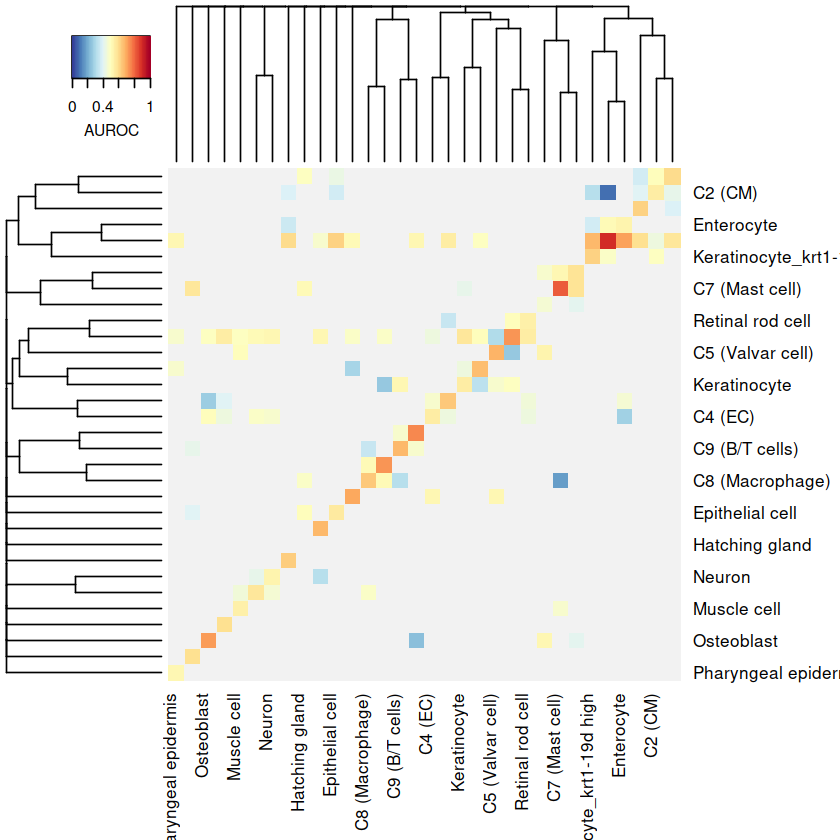

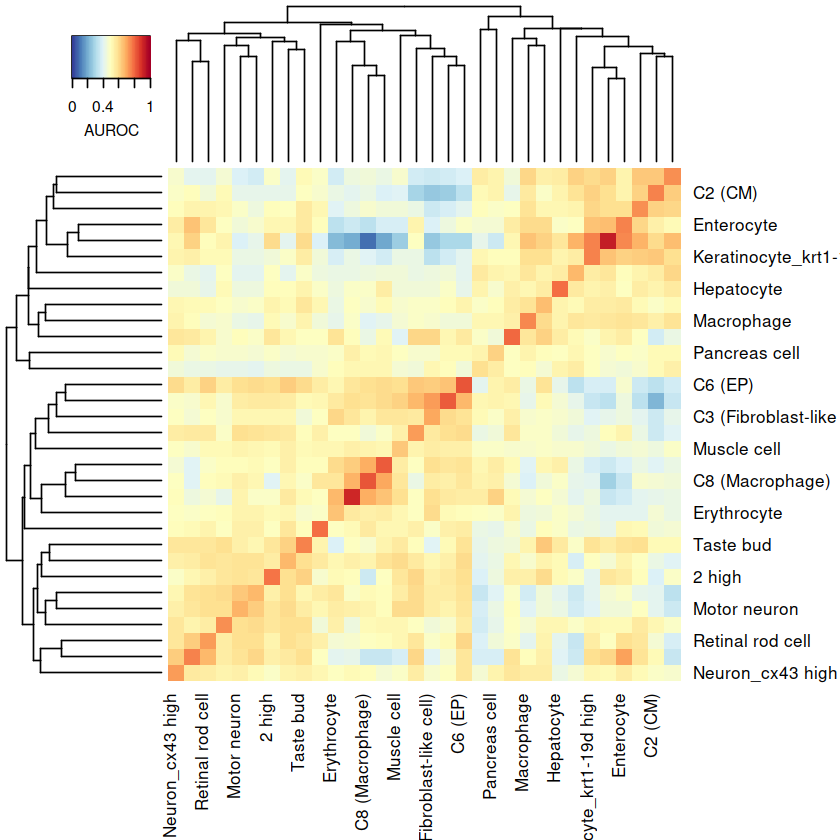

In [40]:
# png('zfish_72hpf_1vsbest.png', width = 15, height = 15, res = 300, units = 'in')
currmat = auroc1
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
# dev.off()

# png('zfish_72hpf_allvsall.png', width = 15, height = 15, res = 300, units = 'in')
currmat = auroc2
rownames(currmat) <- sub(".*\\|", "", rownames(auroc1))
colnames(currmat) = rownames(currmat)
MetaNeighbor::plotHeatmap(currmat, cex = 1)
# dev.off()

In [ ]:
# also do cell type enrichment for marker gene sets in Amalia's data

In [41]:
markers = read.delim('~/heart/human_heart_dev_markers.csv', sep = ',')
markers[1:3,]

Gene   Celltype     
1 MYBPC3 Cardiomyocyte
2 RBM20  Cardiomyocyte
3 RYR2   Cardiomyocyte

In [205]:
# Cui et al 3.8k cells dataset
top_markers = data.frame(gene = ginfo$EnsemblID[match(markers[,1], ginfo$GeneSymbol)], cell_type = as.factor(markers[,2]), group = 'sim_SI')
ct_scores = score_cells(log1p(cpm(mat2)), top_markers)
ct_enrichment = compute_marker_enrichment(ct_scores)
ct_pred = assign_cells(ct_scores)
ct_pred$anno = mat2$Cluster

In [206]:
# verify in original Cui et al data
table(ct_pred$anno)
table(ct_pred$predicted[grep('C1', ct_pred$anno)])


                  C1 (5W)                   C2 (CM) C3 (Fibroblast-like cell) 
                      257                      1492                       786 
                  C4 (EC)          C5 (Valvar cell)                   C6 (EP) 
                      445                       427                        46 
           C7 (Mast cell)           C8 (Macrophage)            C9 (B/T cells) 
                       27                       304                        58 


Cardiomyocyte    Epicardial    Fibroblast    unassigned 
          236            13             5             3 

In [207]:
# ........ now on Amalia's dataset ......... #
ct_scores = score_cells(log1p(cpm(mat3)), top_markers)
ct_enrichment = compute_marker_enrichment(ct_scores)
ct_pred = assign_cells(ct_scores)
ct_pred$anno = mat3$Cluster

In [152]:
table(ct_pred$predicted)


Cardiomyocyte   Endothelial    Epicardial     Erythroid    Fibroblast 
           29           263           245          2081           216 
       Immune        Neuron           SMC    unassigned 
           47            26          1113          1633 

In [153]:
table(ct_pred$predicted[which(ct_pred$anno=='Cardiomyocyte')])

< table of extent 0 >

In [208]:
outmat = ct_pred %>% group_by(anno, predicted) %>% summarize(sumAmount = length(predicted))
head(outmat)

`summarise()` has grouped output by 'anno'. You can override using the `.groups` argument.



anno             predicted     sumAmount
1 Cardiomyocytes-1 Cardiomyocyte  4       
2 Cardiomyocytes-1 Endothelial    2       
3 Cardiomyocytes-1 Epicardial     6       
4 Cardiomyocytes-1 Erythroid      7       
5 Cardiomyocytes-1 Fibroblast    30       
6 Cardiomyocytes-1 Neuron         1

In [209]:
new2 = matrix(0, nrow = length(unique(ct_pred$anno)), ncol = 8)
colnames(new2) = unique(ct_pred$predicted)[1:8]
rownames(new2) = unique(ct_pred$anno) #paste0('cluster_', 1:20)

# map df to matrix
ids = cbind(match(unlist(outmat[,1]), rownames(new2)), match(unlist(outmat[,2]), colnames(new2)), outmat$sumAmount)
ids <- ids[which(!is.na(ids[,2])),]
for(ii in 1:dim(ids)[1])  {new2[ids[ii,1],ids[ii,2]] <- ids[ii,3]}

# get fraction of cell type
outmat2 = sweep(new2, 1, rowSums(new2), FUN = '/')

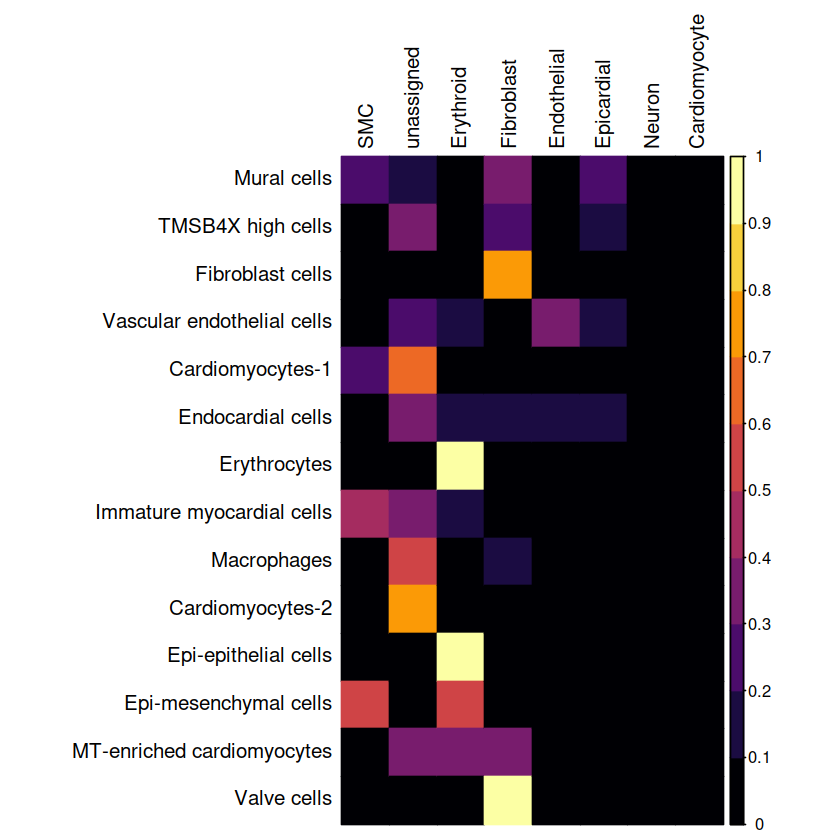

In [212]:
library(corrplot)
library(viridis)
my_palette = viridis::inferno(10)

# png(paste0('chick_D14_markerset_fraction.png'), width = 5, height = 5, res = 300, units = 'in')
# pdf('aa-bbs5-sc-5x5.pdf', width = 5, height = 5)
corrplot(outmat2, method = 'color', is.corr = F, col = my_palette, #col.lim = c(0,1),
         tl.col = 'black', na.label = ' ', na.label.col = 'white')
# dev.off()

In [44]:
markers$EnsID = ginfo$NetworkIDs[match(markers$Gene, ginfo$GeneSymbol)]

In [55]:
table(markers$Celltype)


Cardiomyocyte   Endothelial    Epicardial     Erythroid    Fibroblast 
           10            10            10             9            10 
       Immune        Neuron           SMC 
           10            10            10 

In [57]:
markers$Celltype[which(is.na(match(markers$EnsID, rnames)))]

[1] "Endothelial" "SMC"         "SMC"         "SMC"

In [47]:
library(rhdf5)
file1 = '/data/CoCoCoNet/networks/human_prioAggNet.hdf5'
h5ls(file1)
rnames = h5read(file1, 'row')

group name      otype       dclass dim          
0 /     agg       H5I_DATASET FLOAT  24631 x 24631
1 /     chunkSize H5I_DATASET FLOAT  1            
2 /     col       H5I_DATASET STRING 24631        
3 /     row       H5I_DATASET STRING 24631

In [51]:
ids = match(markers$EnsID, rnames)
ids = ids[!is.na(ids)]

In [53]:
currmat = h5read(file1, 'agg', index = list(ids,ids))

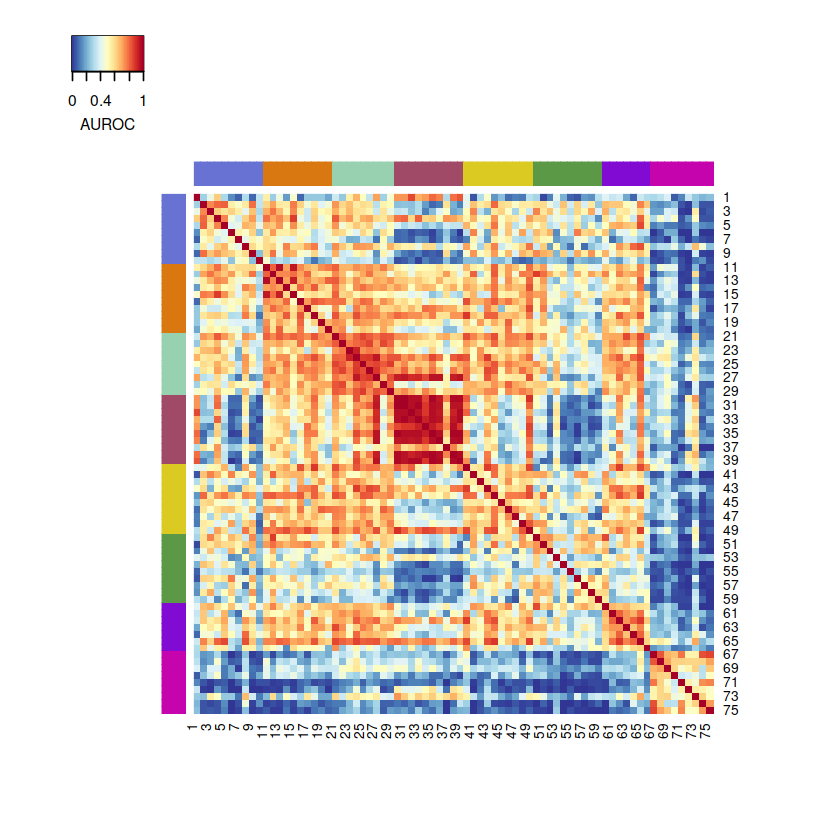

In [72]:
# cardio, fibro, endo, immune, epi, neuron, smc, ery
mods = c(10, 10, 9, 10, 10, 10, 7, 9)
colpal = c('#6872d2', '#d97710', '#97d1b0', '#a14a67', '#daca21', '#5b9946', '#820bd3', '#c504ad')
ColSideColors1 = unlist(lapply(1:length(mods), function(pp) (rep(colpal[pp], mods[pp]))))                            

# pdf('mouse-rhesus-heatmap.pdf', width = 8, height = 8) 
# png('human-exp-heatmap.png', width = 8, height = 8, res = 300, units = 'in') 
MetaNeighbor::plotHeatmap(currmat, dendrogram = 'none', Rowv = FALSE, Colv = FALSE, ColSideColors = ColSideColors1, RowSideColors = ColSideColors1)
# dev.off()

In [73]:
markers[markers$Celltype=='Neuron',]

Gene     Celltype EnsID          
51 NRXN1    Neuron   ENSG00000179915
52 CHL1     Neuron   ENSG00000134121
53 XKR4     Neuron   ENSG00000206579
54 INSC     Neuron   ENSG00000188487
55 ZNF536   Neuron   ENSG00000198597
56 NKAIN3   Neuron   ENSG00000185942
57 SLC35F1  Neuron   ENSG00000196376
58 PTPRZ1   Neuron   ENSG00000106278
59 GRIK3    Neuron   ENSG00000163873
60 RASGEF1C Neuron   ENSG00000146090